In [95]:
from IPython.core.display import display, HTML
import numpy as np
display(HTML("<style>.container { width:90% !important; }</style>"))

np.set_printoptions(linewidth=250, suppress=True)
np.set_printoptions(threshold=np.nan)

In [5]:
import numpy as np
import sys
import os
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import random
import torchvision as tv
import PIL
import random
import pickle
import pprint

from dataset_processing import *
from UNet import *
from training_tools import *
from training import *

%load_ext autoreload
%autoreload 2

#device = torch.device('cpu')
#device = torch.device('cuda:2')

#TODO:
# try switching BN ReLU ordering
# try elu instead of relu
# data augmentation
# refine training set
# subtract mean from inputs -- > not necessary b/c of batchnorm?
# feed logits into BCE loss
# weight initalization
# stuff in paper
# try dropout

#torch.cuda.empty_cache()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# processing datasets
reload = False

if reload:
    mask_path = "masks_filtered"
    masks = process_masks(mask_path, 256)
    pickle.dump(masks,open("cache/masks.p","wb"))

    img_path = "/data5/drone_machinelearning/Datasets/OOWL0.4/crop_drone"
    oowl = process_oowl(img_path, 256, masks)
    pickle.dump(oowl,open("cache/oowl.p","wb"))
    
    keys = (list(oowl.keys()))
    random.shuffle(keys)
    training_keys = keys[:3400]
    validation_keys = keys[3400:3700]
    test_keys = keys[3700:]  
    pickle.dump(training_keys, open("cache/train_keys.p", "wb"))
    pickle.dump(validation_keys, open("cache/val_keys.p", "wb"))
    pickle.dump(test_keys, open("cache/test_keys.p", "wb"))   
else:
    masks = pickle.load(open("cache/masks.p", "rb"))
    oowl = pickle.load(open("cache/oowl.p", "rb"))
    train_keys = pickle.load(open("cache/train_keys.p","rb"))
    val_keys = pickle.load(open("cache/val_keys.p","rb"))
    test_keys = pickle.load(open("cache/test_keys.p","rb"))
    


500
1000
1500
2000
2500
3000
3500
4000
500
1000
1500
2000
2500
3000
3500
4000


In [16]:
GPU = '7'
device = torch.device('cuda:'+GPU)
#unet = UNet(True, 'relu').to(device=device)
print(str(device))



cuda:7


In [46]:
trainer = Trainer(unet, "test", device, training_keys, validation_keys, oowl, masks)
trainer.train(0.001)

Epoch 0 .............................................
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
Percent done: 0.0
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu
Percent done: 0.000588235294117647
gu
gu
gu
gu
gu
gu
gu
gu
gu
gu


KeyboardInterrupt: 

In [ ]:
u_test = UNet(True, 'elu')
out = u_test(torch.tensor(oowl[test_set[1]], dtype = torch.float).unsqueeze_(0).permute(0,3,1,2))
print(out.size())

In [1]:
pic_id = list(oowl.keys())[2345]
pic = oowl[pic_id]
mask = masks[pic_id]
mask = np.squeeze(mask)
mask = np.stack((mask,mask,mask))
mask = mask.transpose(1,2,0) * 255
mask = mask.astype(np.uint8)
#print(np.array(mask).shape)
#print(mask)

seed =random.randint(0,2**32)

jitter = T.ColorJitter(brightness = 0.3, contrast = 0.3, saturation = 0.3, hue = 0.1)
horiz = T.RandomHorizontalFlip()
crop = T.RandomResizedCrop(256, scale=(0.3,1.0), interpolation = PIL.Image.NEAREST)
rotate = T.RandomRotation(3, expand = False, resample = PIL.Image.BILINEAR)

augumentation_tricks = T.Compose([jitter,horiz,crop,rotate])

#zoom_in = torchvision.transforms.functional.affine()

transformed_pic = T.ToPILImage()(pic)
random.seed(seed)
transformed_pic = augumentation_tricks(transformed_pic)
transformed_pic = torchvision.transforms.functional.affine(transformed_pic,0,(0,0),1.06,0)
random.seed(seed)
transformed_mask = augumentation_tricks(T.ToPILImage()(mask))
transformed_mask = torchvision.transforms.functional.affine(transformed_mask,0,(0,0),1.06,0)
#transformed = T.ToTensor()(transformed)
#print(T.ToTensor()(transformed_mask)[2][2])
transformed_mask = T.ToTensor()(transformed_mask).detach().cpu().numpy()
show_pic(transformed_pic)
transformed_mask = transformed_mask.transpose(1,2,0)
print(transformed_mask.shape)
show_pic(transformed_mask)

NameError: name 'oowl' is not defined

In [14]:
 def show_pic(in_pic):
    in_pic = np.array(in_pic)
    if len(in_pic.shape)== 4:
        in_pic = in_pic.squeeze(0)
    if in_pic.shape[0] == 1:

        orig_pic = in_pic
        pic = np.stack((orig_pic[0], orig_pic[0], orig_pic[0]),0)
        pic = pic*255
        pic = pic.transpose(1,2,0)
    else:
        pic = cv2.cvtColor(in_pic, cv2.COLOR_BGR2RGB)
    plt.imshow(pic)
    plt.show()
   

def see_seg(pic_id, model, device):
    
    image_dict = oowl
    #pic_id = list(image_dict.keys())[3000]
    #pic = torch.tensor(image_dict[pic_id],dtype=torch.float)
    pic = image_dict[pic_id]
    show_pic(pic)


    net_input = np.expand_dims(pic, 0)
    net_input = net_input.transpose(0,3,1,2)
    net_input = torch.tensor(net_input)
    net_input = net_input.to(device=device, dtype=torch.float32)
    predicted_mask = model(net_input)
    predicted_mask_converted = predicted_mask.detach().cpu().numpy()
    show_pic(predicted_mask_converted)
    
    return predicted_mask

#show_pic(masks[list(masks.keys())[2]])

#see_seg(test_set[250], uNet)
#see_seg(training_set[100])

In [113]:
def get_IOU(predicted, gt):

    predicted_np = predicted.detach().cpu().numpy()
    gt_np = gt.detach().cpu().numpy()    
    intersection = np.sum(np.logical_and(predicted_np,gt_np))
    union = np.sum(np.logical_or(predicted_np, gt_np))
    return np.float(intersection)/union



In [15]:
save_path = "./models/2018-09-21-14-40-12_RELU_867973"
device = torch.device('cuda:4')
uNet_new = torch.load(save_path).to(device = device)
lc = LossChecker("validation", validation_keys, oowl, masks, device)

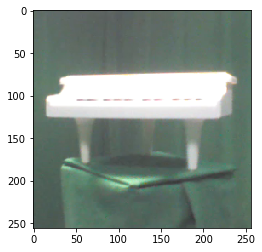

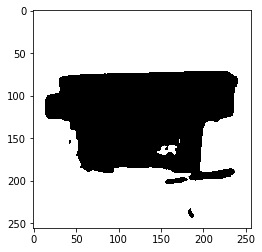

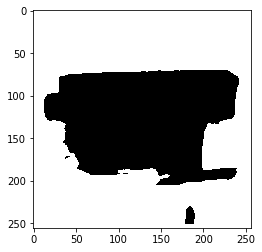

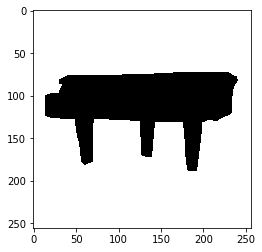

0.8231409144927818


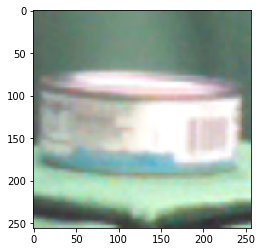

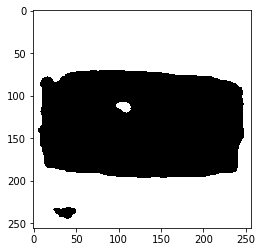

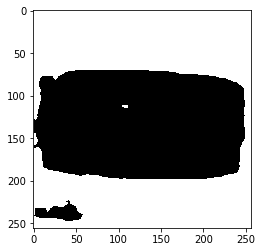

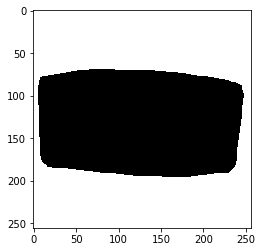

0.9349629785222917


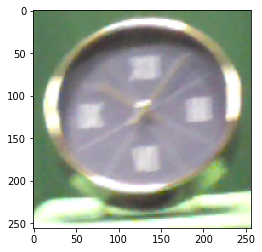

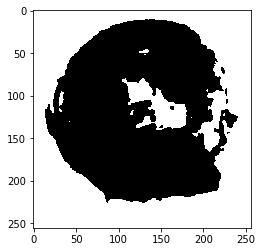

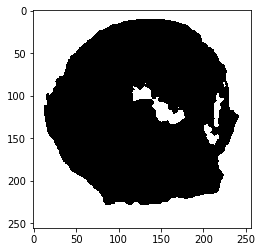

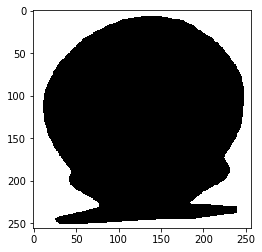

0.6933672242640745


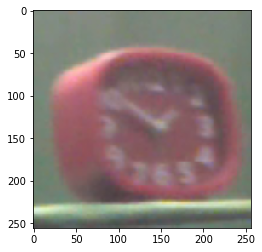

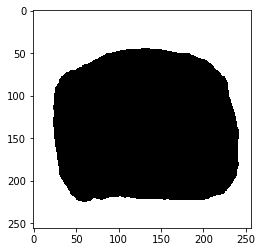

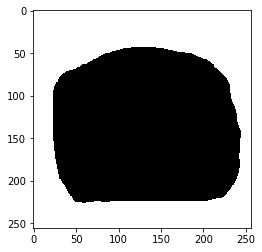

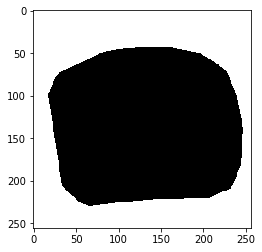

0.942713567839196


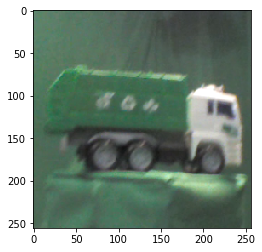

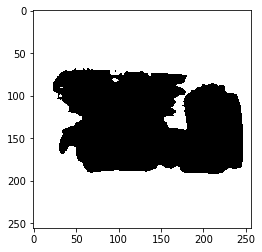

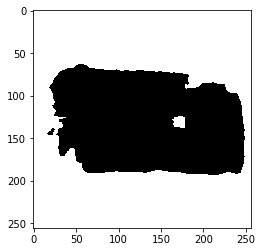

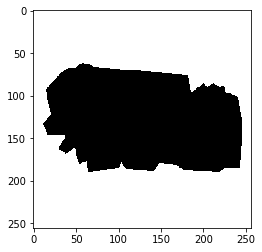

0.945711005412498


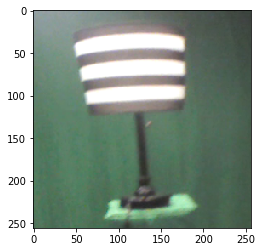

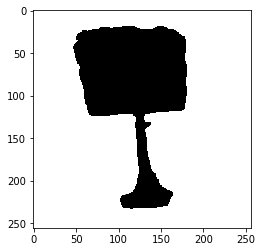

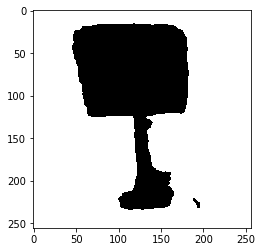

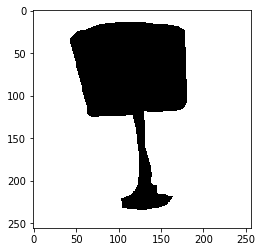

0.9635398018856666


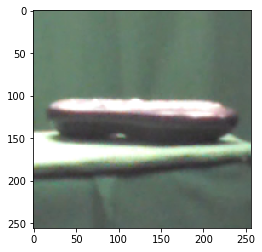

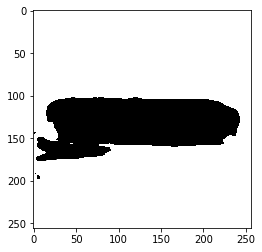

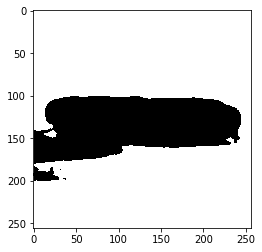

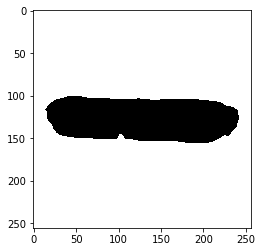

0.9158621687095492


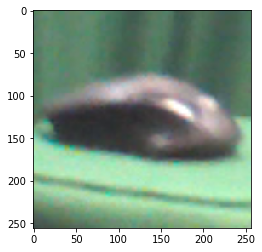

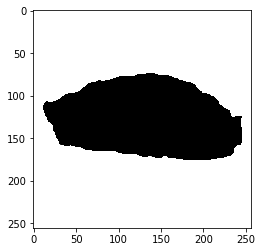

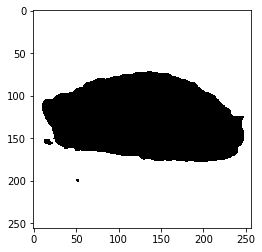

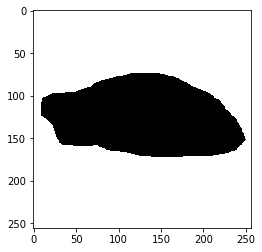

0.962995229205559


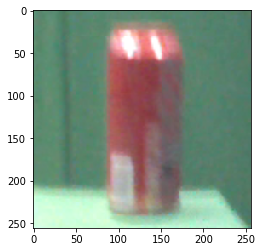

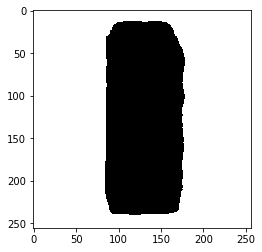

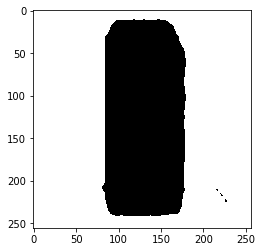

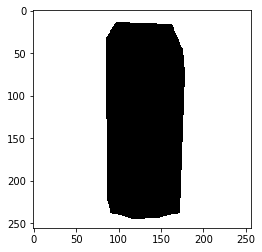

0.9737411723549861


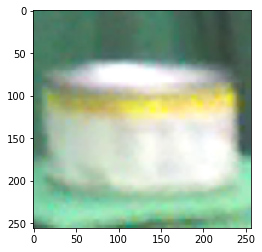

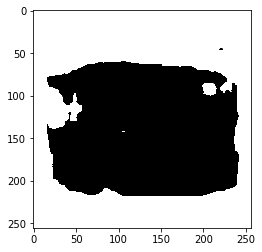

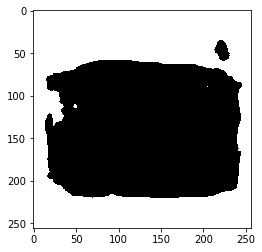

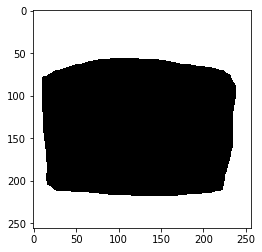

0.8883186995728524


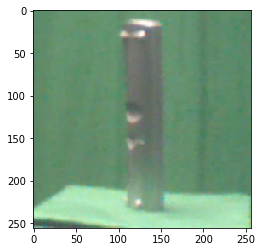

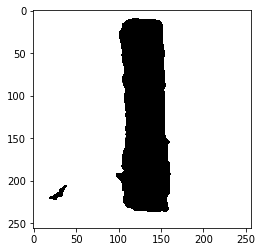

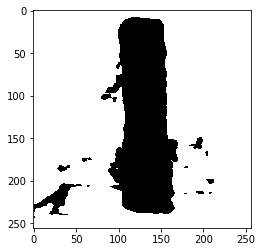

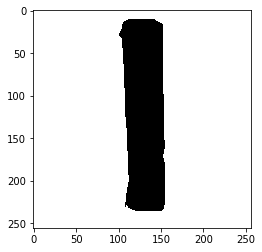

0.9232688032102381


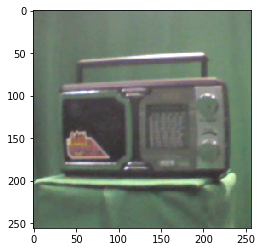

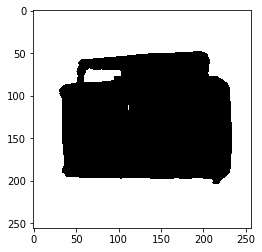

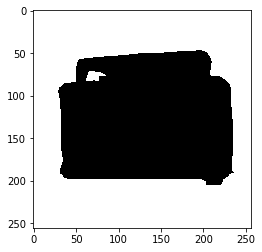

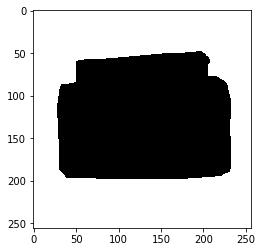

0.9584969444805617


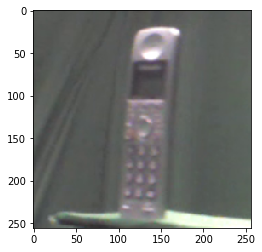

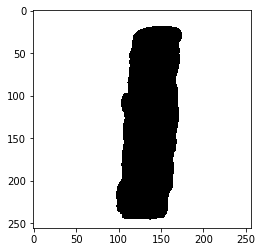

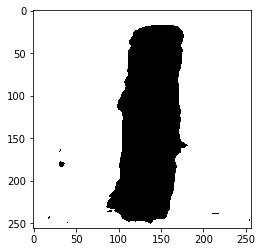

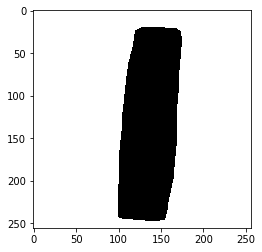

0.9712920511481246


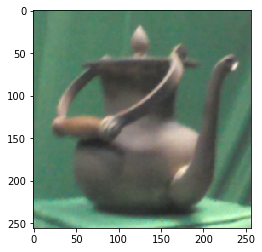

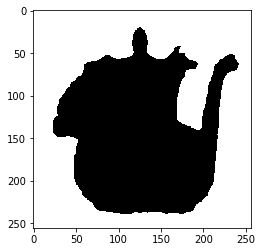

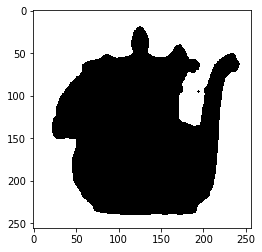

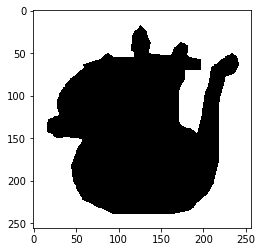

0.9573179281527805


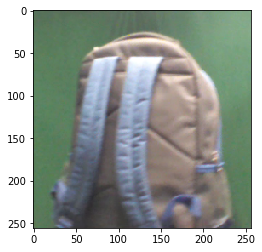

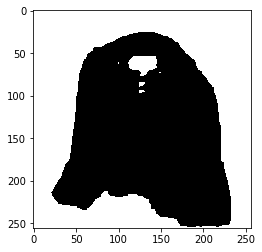

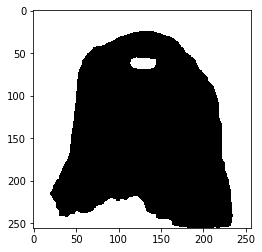

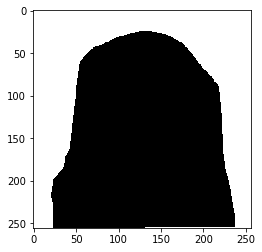

0.8564758491434584


In [116]:
for img in test_keys[60:75]:
    predicted = see_seg(img, uNet_new, device)
    predicted_binarized = binarize(predicted)
    gt = torch.tensor(masks[img]).unsqueeze(0)
    show_pic(predicted_binarized.detach().cpu().numpy())
    show_pic(gt)
    print(get_IOU(predicted_binarized,gt))
    